  # Description

  
  🌟 Objective: Classification with various techniques on this dataset.

  Dataset link: https://huggingface.co/datasets/dair-ai/emotion?library=datasets
 
 📋 Tasks:
   1. **Baseline Implementation**: 
      - Train a tf-idf + logistic regression classifier with 5%, 10%, 25%, 50%, and 100% of the data.
      - Plot the learning curve (f1/precision/recall) based on the volume of data.
   2. **BERT Implementation**: 
      - Train a BERT classifier with 5%, 10%, 25%, 50%, and 100% of the data.
      - Add its learning curve (f1/precision/recall) to the previous plot.
   3. **BERT Model with Limited Data**: 
      - Train a setfit model using only 32 labeled examples and assess its performance.
      - Add a horizontal line on the previous plot.
   4. **Zero Shot Technique**: 
      - Apply a large language model in a zero-shot learning setup with an LLM such as chatGPT.
      - If you can't apply it on all the data, a small sample should suffice.
      - Add a horizontal line on the previous plot.
   5. **Generate New Data from Scratch**: 
      - Use the LLM to generate a few samples for each class (10, 50, 100).
      - Recreate the learning curve and add the performances to the previous plot.
   6. **Bonus Question**: 
      - Examine some differences in what the models have learned.
 
 🔗 Helpful Link:
 This link might be useful for interacting with the LLM: [Native JSON Output from GPT-4](https://yonom.substack.com/p/native-json-output-from-gpt-4). It explains how to ask the model to provide information in a JSON format, which will be easier to organize.

# Housekeeping

Let's start by loading all the necessary libraries and the dataset.

In [1]:
import plotly.graph_objects as go
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from random import randint

from src.data import Data
from src.utils import Utils
from src.bert import BERT
from src.baseline import Baseline
from src.llm_data import LLMData



In [2]:
Data().ds

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [3]:
data = Data().ds
# Print a few samples from the training set
print("Training set samples:\n")
for i, sample in enumerate(data['train'].select(range(5))):
    print(f"Sample {i+1}:")
    print(f"Text: {sample['text']}")
    print(f"Label: {sample['label']}")
    print()

# Print the unique labels
unique_labels = set(data['train']['label'] + data['validation']['label'] + data['test']['label'])
print("Unique labels:", unique_labels)

Training set samples:

Sample 1:
Text: i didnt feel humiliated
Label: 0

Sample 2:
Text: i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake
Label: 0

Sample 3:
Text: im grabbing a minute to post i feel greedy wrong
Label: 3

Sample 4:
Text: i am ever feeling nostalgic about the fireplace i will know that it is still on the property
Label: 2

Sample 5:
Text: i am feeling grouchy
Label: 3

Unique labels: {0, 1, 2, 3, 4, 5}


# Visualisation

The data is a bit contaminated, so I had to do some cleaning before in order to get some nice visualisation of the more common (and relevant words) in the dataset. The criteria that I used can be found in the `Data` and `Utils` classes.

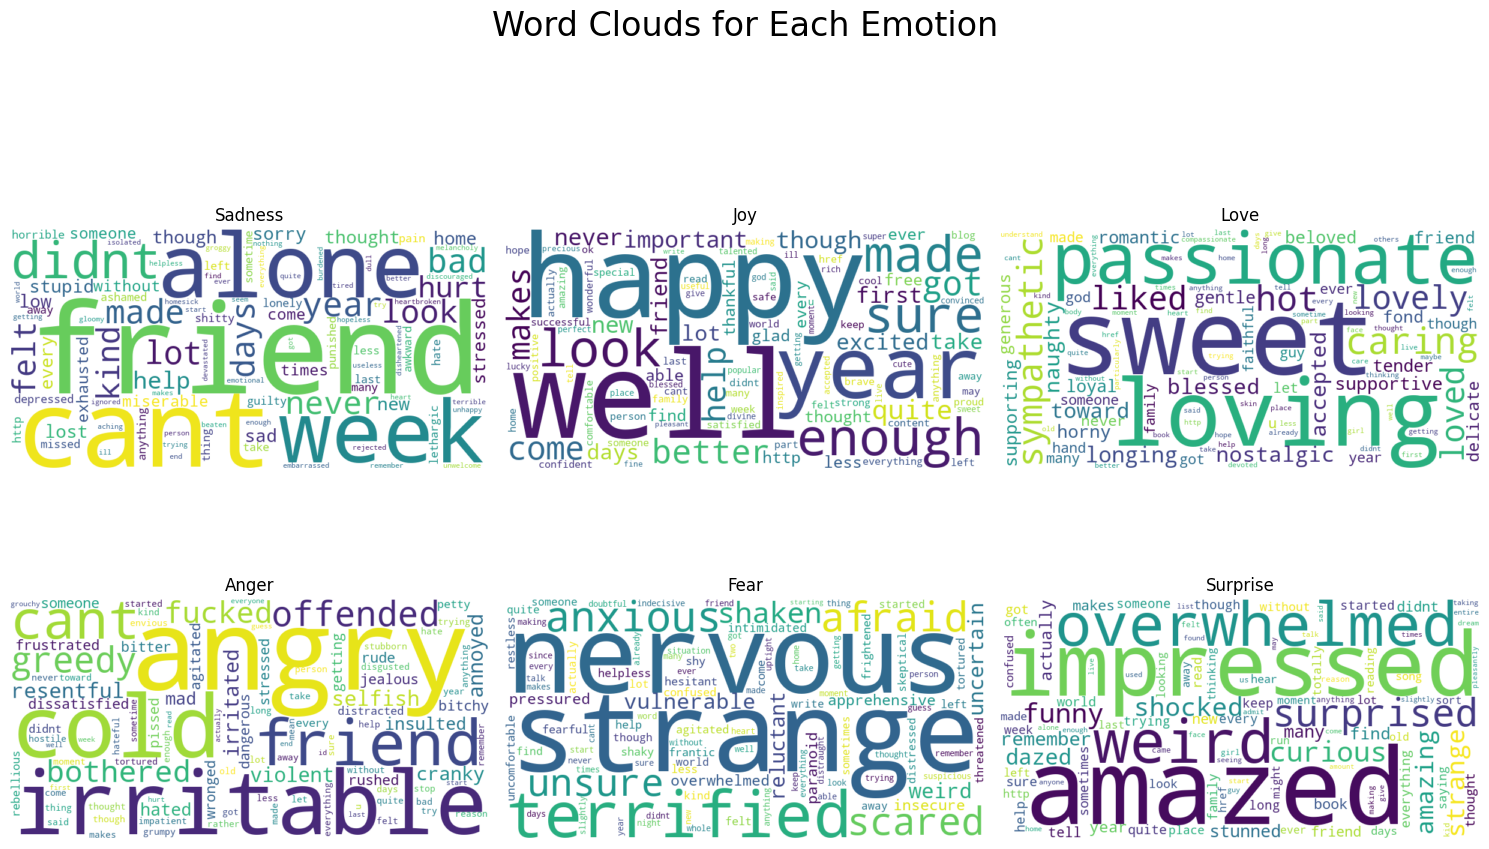

In [4]:
word_cloud = Data().plot_word_clouds()

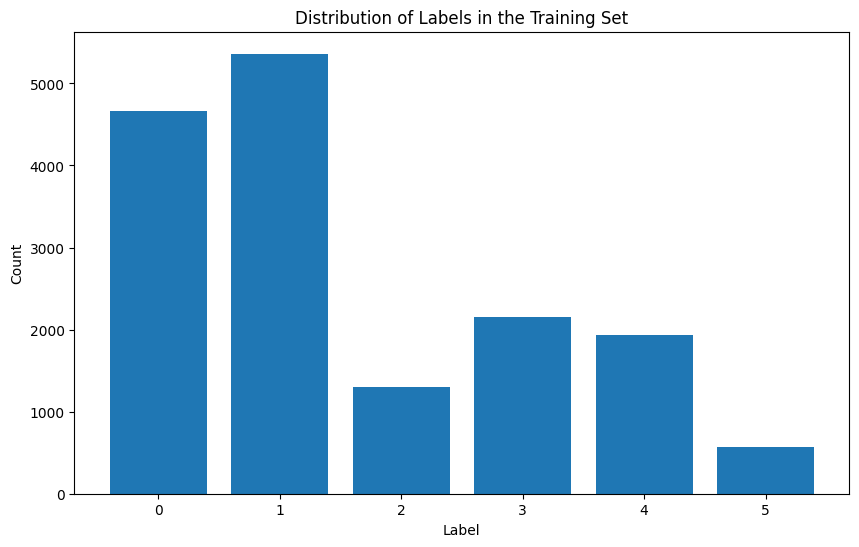

In [5]:
label_dist = Data().plot_label_distribution()

# Baseline Implementation

In [6]:

baseline_results = pd.read_csv('results/data/baseline.csv')
fig = go.Figure()
fig = Utils.plot_metrics(baseline_results)
fig.update_layout(
    title='Learning Curve: TF-IDF + Logistic Regression',
    xaxis_title='Percentage of Training Data',
    yaxis_title='Score',
    legend_title='Metric',
    template='plotly_white'
)

fig.show()

# BERT Implementation

BERT (Bidirectional Encoder Representations from Transformers) is a state-of-the-art transformer-based model developed by Google. It is designed to understand the context of words in a sentence by considering both the left and right context simultaneously. BERT is pre-trained on a vast amount of text data and can be fine-tuned for various specific tasks such as text classification, question answering, and more. With the implementation of BERT, the performance has improved at every percentage of training data. 

In [7]:

bert_results = pd.read_csv('results/data/bert.csv')
bert_results
fig = go.Figure()
fig = Utils.plot_metrics(bert_results)
fig.update_layout(
    title='Learning Curve: BERT',
    xaxis_title='Percentage of Training Data',
    yaxis_title='Score',
    legend_title='Metric',
    template='plotly_white'
)

fig.show()


 # Overview of the Results
 
 The figure below illustrates the performance of four different methods (Baseline, BERT, SetFit, and Zero-Shot) across the original dataset, evaluated using four distinct metrics. For SetFit and Zero-Shot methods, the performance is represented by horizontal lines since `num_samples` is fixed in advance.
 
 A key observation is the contrasting dependence on `num_samples` between SetFit and Zero-Shot methods. SetFit's performance improves with an increase in `num_samples` due to a larger training sample size. Conversely, Zero-Shot's performance deteriorates with more `num_samples` as GPT has to predict more samples without prior fine-tuning.
 
 Overall, BERT consistently outperforms all other methods. SetFit surpasses the baseline model for certain data percentages and is also influenced by `num_samples`. Zero-Shot, however, performs the worst, indicating the necessity for some fine-tuning.

In [8]:
def plot_metrics(df, fig=None, label=None, legend=True, color=None, x_limits=(0, 90)):
    metrics = ['accuracy', 'f1', 'precision', 'recall']

    # Normalize percentage values if they're not already in the 0-100 range
    if df['percentage'].max() <= 1:
        df['percentage'] = df['percentage'] * 100

    # Sort the dataframe by percentage
    df = df.sort_values('percentage')

    if fig is None:
        fig, axs = plt.subplots(2, 2, figsize=(15, 12))
    else:
        axs = fig.get_axes()

    axs = np.array(axs).ravel()

    M = randint(1,10)
    markers = ['o', 'x']
    j = randint(0,1)
    for i, metric in enumerate(metrics):
        metric_data = df[df['metric'] == metric]
        if len(metric_data) == 1:

            axs[i].plot(np.linspace(x_limits[0], x_limits[1], M), [metric_data['value'].values[0]] * M, color=color, marker=markers[j], linestyle='-', label=label)
        else:
            axs[i].plot(metric_data['percentage'], metric_data['value'], marker='o', label=label, color=color)
        axs[i].set_title(f'{metric.capitalize()}')
        axs[i].set_xlabel('Percentage')
        axs[i].set_ylabel(metric.capitalize())
        if legend and i == 0:  # Only add legend to the first subplot
            axs[i].legend()
        axs[i].grid(True, linewidth=0.5)
        axs[i].set_xlim(x_limits)  # Set x-axis limits based on input
        for spine in ['top', 'right', 'left', 'bottom']:
            axs[i].spines[spine].set_visible(False)

    fig.tight_layout()
    return fig


/var/folders/9v/r8dlqxtj13b3qtjcst6bm0d40000gn/T/ipykernel_99253/1704215616.py:14: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



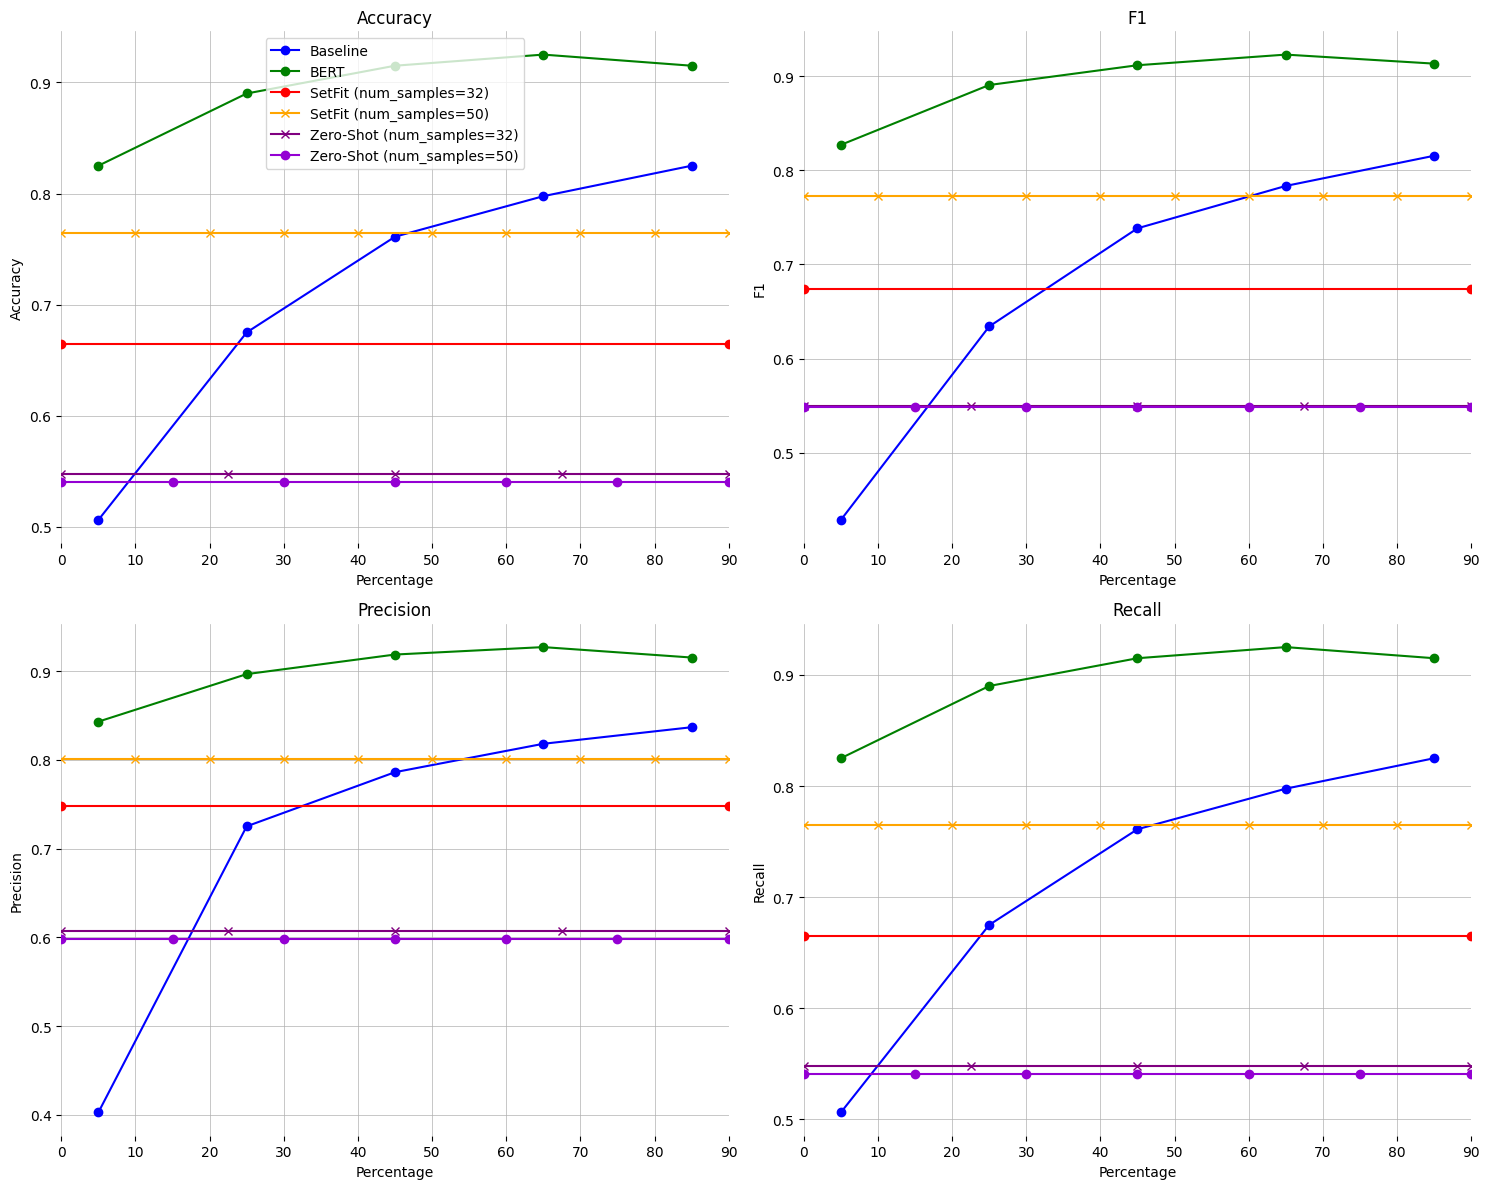

In [14]:
baseline_results = pd.read_csv('results/data/baseline.csv')
bert_results = pd.read_csv('results/data/bert.csv')
setfit_results_32 = pd.read_csv('results/data/setfit_num_samples=32.csv')
setfit_results_50 = pd.read_csv('results/data/setfit_num_samples=50.csv')
gpt_results_32 = pd.read_csv('results/data/zeroshot_num_samples=32.csv')
gpt_results_50 = pd.read_csv('results/data/zeroshot_num_samples=50.csv')

fig = plot_metrics(baseline_results, label='Baseline', color='blue')
fig = plot_metrics(bert_results, fig=fig, label='BERT', color='green')
fig = plot_metrics(setfit_results_32, fig=fig, label='SetFit (num_samples=32)', color='red')
fig = plot_metrics(setfit_results_50, fig=fig, label='SetFit (num_samples=50)', color='orange')
fig = plot_metrics(gpt_results_32, fig=fig, label='Zero-Shot (num_samples=32)', color='purple')
fig = plot_metrics(gpt_results_50, fig=fig, label='Zero-Shot (num_samples=50)', color='darkviolet')
fig.show()



# LLM sample generator

The class `LLMData` generates a sample of a given size (`num_samples_per_class`). These data are saved with the common name `gpt_data` + a suffix indicating the size of the sample. I am going to try to repeat the same analysis than before but over this data. Notice that the size is reduced. Also, I'm going to try to apply the models trained over the original dataset over the new data.

As a first example, simply compute the baseline model over the new data. As we can see, if we take less than the 40\% of the data, the scores are very low. After that, the scores are very high.

In [10]:
data_llm = LLMData(num_samples_per_class=50)

baseline = Baseline(
                data = Data(),
                seed = 100,
                test_size = 0.20,
                num_percentiles = 20
        )
baseline_results_llm = baseline.get_results(data=data_llm, model=baseline.model)
baseline_results_llm.to_csv('results/data/baseline_llm.csv', index=False)

Processing percentages:   0%|          | 0/5 [00:00<?, ?it/s]/Users/rubenffuertes/Library/CloudStorage/GoogleDrive-ruben.fernandez@summer.bse.eu/Mi unidad/2024_bse_summer_school/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

Processing percentages: 100%|██████████| 5/5 [00:00<00:00, 103.83it/s]


In [15]:
baseline_results_llm = pd.read_csv('results/data/baseline_llm.csv')
fig = go.Figure()
fig = Utils.plot_metrics(baseline_results_llm)
fig.update_layout(
    title='Learning Curve: TF-IDF + Logistic Regression',
    xaxis_title='Percentage of Training Data',
    yaxis_title='Score',
    legend_title='Metric',
    template='plotly_white',
    width=800,
    height=500
)

fig.show()

Let's do the same with `BERT`. First, train the BERT model over the original dataset. Then, train different BERT models over the new data. Finally, apply the original model over the new data.

In [16]:

bert = BERT(data=Data(), seed=100, test_size=0.20, num_percentiles=20)
bert_results = bert.results

Using device: mps


Processing percentages:   0%|          | 0/5 [00:00<?, ?it/s]Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:

bert_llm1 = BERT(data=LLMData(num_samples_per_class=100), seed=100, test_size=0.20, num_percentiles=20)
bert_results_llm1 = bert_llm1.results
bert_results_llm1.to_csv('results/data/bert_llm1.csv', index=False)

Using device: mps


Processing percentages:   0%|          | 0/5 [00:00<?, ?it/s]Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Processing percentages: 100%|██████████| 5/5 [00:04<00:00,  1.13it/s]


In [ ]:

bert_results_llm = pd.read_csv('results/data/bert_llm.csv')
bert_results_llm
fig = go.Figure()
fig = Utils.plot_metrics(bert_results_llm)
fig.update_layout(
    title='Learning Curve: BERT',
    xaxis_title='Percentage of Training Data',
    yaxis_title='Score',
    legend_title='Metric',
    template='plotly_white',
    width=800,
    height=500
)

fig.show()

In [ ]:
bert = BERT(data=Data(), seed=100, test_size=0.20, num_percentiles=20)
bert_results_llm2 = bert.get_results(data=LLMData(num_samples_per_class=50), model=bert.models[bert.percentages[3]])
bert_results_llm2.to_csv('results/data/bert_llm2.csv', index=False)

Using device: mps


KeyError: 0.65

In [ ]:

bert_results_llm = pd.read_csv('results/data/bert_llm.csv')
bert_results_llm
fig = go.Figure()
fig = Utils.plot_metrics(bert_results_llm)
fig.update_layout(
    title='Learning Curve: BERT',
    xaxis_title='Percentage of Training Data',
    yaxis_title='Score',
    legend_title='Metric',
    template='plotly_white',
    width=800,
    height=500
)

fig.show()